In [1]:
import tensorflow as tf
import tensorflow_text as text
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import pickle
from collections import Counter
import json
import subprocess
import keras_hub

print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2025-10-12 23:20:07.379865: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/archfishgame/deep/deep-learning/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-12 23:20:10.328789: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:926] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


2.16.2
1 Physical GPUs, 1 Logical GPUs


2025-10-12 23:20:14.296246: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:926] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-12 23:20:14.296287: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:926] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-12 23:20:14.297108: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:926] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-12 23:20:14.297160: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:926] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-12 23:20:14.297181: I external/local_xla/xla/stream_executor/rocm/rocm_executor.

## Exploring the data

I loaded all the training image names and their attached hypothesis and labels.

I printed out the size of the dataset and the ratio of entangled to contradictory images in the dataset as well as a random sample of images to get an idea of how the dataset looks. 

The ratio of entailment to contradiction appears to be close to 1 to 1 with on average one of each for every image this means that the dataset should be fairly balanced and I shouldn't need to augment the data to account for imbalance in training. 
On the other hand the images have differing resolutions that will require scaling to a common resolution for the model to be able to process correctly. 
Looking at the images there is a wide variety of lighting conditions, backgrounds, and resolutions this information will be useful for implementing data augmentation.   

Number of images 19573
Vocab length 12563
hypothesis count 39129
Dataset balance Counter({'entailment': 19619, 'contradiction': 19510})


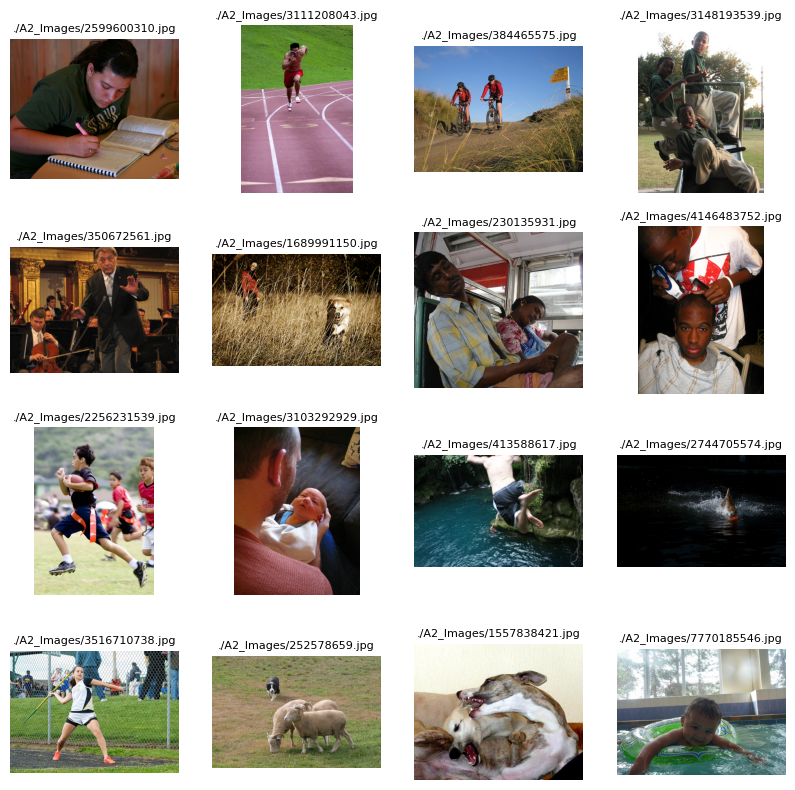

In [2]:
# load images and labels 

labelSet = Counter()
dataDict = {}
vocab = set(['[UNK]'])

datasetLen = 0
with open("./A2_train_v3.jsonl", "r") as jsonFile:
	for line in jsonFile:
		datasetLen += 1
		loadedLine = json.loads(line)
		if loadedLine["Image_ID"] not in dataDict:
			dataDict[loadedLine["Image_ID"]] = []

		labelSet[loadedLine["Label"]] += 1

		hypo = loadedLine["Hypothesis"].lower()
		vocab.update(hypo.split())

		dataDict[loadedLine["Image_ID"]].append((hypo, loadedLine["Label"]))

labelTuple = tuple(labelSet.keys())
vocab = list(vocab)

vocabIndex = {vocab[i]: i for i in range(len(vocab))}

print(f'Number of images {len(dataDict.keys())}')
print(f'Vocab length {len(vocabIndex)}')
print(f'hypothesis count {datasetLen}')
print(f'Dataset balance {labelSet}')

gridSize = 4
plt.figure(figsize=(10, 10)) 

for i in range(gridSize ** 2):
	image_file = './A2_Images/' + random.choice(list(dataDict.keys())) + '.jpg'
	img = mpimg.imread(image_file)

	plt.subplot(gridSize, gridSize, i + 1)
	plt.imshow(img)
	plt.title(image_file, fontsize=8)
	plt.axis('off') # Hide axes for cleaner image display

plt.show()

## Loading the data

TODO

In [5]:
# load the glove embeddings 

def getGlove():
  print('Downloading glove')
  subprocess.run(['wget', 'https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip'])
  subprocess.run(['unzip', '-q glove.6B.zip'])

def generateMatrix(dim):
    print('parsing glove data')
    embeddingMatrix = np.zeros((len(vocab), dim))
    embeddedVocab = []
    
    with open(f'glove.6B.{dim}d.txt', encoding="utf-8") as gloveFile:
      for line in gloveFile:
        values = line.split()
        word = values[0]
    
        if word in vocab:
          embeddingMatrix[vocabIndex[word]] = np.asarray(values[1:], dtype='float32')
          embeddedVocab.append(word)

    print(f'embedded {len(embeddedVocab)} out of {len(vocab)}')
    return embeddingMatrix, [i for i in vocab if i not in embeddedVocab]


embeddingDim = 200
embeddingMatrix = None
notEmbeddedVocab = None

if not os.path.isfile(f'glove.6B.{embeddingDim}d.txt'):
  getGlove()

if os.path.isfile(f'embeddingMatrix.{embeddingDim}d.pkl'):
  with open(f'embeddingMatrix.{embeddingDim}d.pkl', 'rb') as f:
    embeddingMatrix = pickle.load(f)

  print('loaded matrix')
else:
  embeddingMatrix, notEmbeddedVocab = generateMatrix(embeddingDim)

  with open(f'embeddingMatrix.{embeddingDim}d.pkl', 'ab') as f:
    pickle.dump(embeddingMatrix, f)

  print('saved matrix')

  print(len(notEmbeddedVocab))

loaded matrix


## Creating the tensorflow dataset

TODO

In [ ]:

X1array = []
X2array = []
YArray = []

for key, hypoAndLabels in dataDict.items():
	img = f'./A2_Images/{key}.jpg'

	for hypo, label in hypoAndLabels:
		label = tf.convert_to_tensor([labelTuple.index(label)])
		label.set_shape([1])

		X1array.append(img)
		X2array.append(hypo)
		YArray.append(label)

tokenizer = keras_hub.models.Tokenizer.from_preset("bert_base_en")

X1Numpy = np.array(X1array)
X2Numpy = text.pad_model_inputs(tokenizer.tokenize(X2array)
YNumpy = np.array(YArray, dtype='uint8')

dataset = tf.data.Dataset.from_tensor_slices(({'image': X1Numpy, 'text': X2Numpy}, YNumpy))

imageChannels = 3
imageRes = 224
patchesPerImage = 8

patchRes = int(imageRes / patchesPerImage) 
patchNum = patchesPerImage ** 2 * imageChannels 

def getImage(path):
	img = tf.io.read_file(path)
	img = tf.io.decode_image(img, channels=imageChannels, dtype=tf.float32)
	img = tf.image.resize(img, (imageRes, imageRes))

	return img

def getImageWrapper(x, y):
	img = tf.py_function(func=getImage, inp=[x['image']], Tout=tf.float32)
	img.set_shape([imageRes, imageRes, imageChannels])

	x['image'] = img 
	return x, y

dataset = dataset.map(getImageWrapper, num_parallel_calls=8)

testSize = int(datasetLen * 0.05)
valSize = int(datasetLen * 0.05)
trainSize = int(datasetLen - testSize - valSize)
batchSize = 100

def optimize(ds, name):
	ds = ds.batch(batchSize) 
	ds = ds.cache(name + 'dataset.cache') 
	ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
	
	return ds

def getTest(ds):
	ds = ds.take(testSize) 
	ds = optimize(ds, 'test')
	
	return ds

def getVal(ds):
	ds = ds.skip(testSize)
	ds = ds.take(valSize) 
	ds = optimize(ds, 'val')

	return ds

def getTrain(ds):
	ds = ds.skip(valSize + testSize)
	ds = ds.take(trainSize)
	ds = optimize(ds, 'train')

	return ds

testDS = getTest(dataset)
valDS = getVal(dataset)
trainDS = getTrain(dataset)


print(f"test data batches {tf.data.experimental.cardinality(testDS).numpy()}")
print(f"val data batches {tf.data.experimental.cardinality(valDS).numpy()}")
print(f"train data batches {tf.data.experimental.cardinality(trainDS).numpy()}")
print(f'ratios test:{testSize} val:{valSize} train:{trainSize}')


ValueError: Can't convert non-rectangular Python sequence to Tensor.

In [19]:
tokenizer.tokenize('no')

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([11284], dtype=int32)>

In [32]:
# clear dataset cache

for f in os.listdir('./'):  
	if 'dataset.cache' in f:
		os.remove(f)

# Training

ToDo


In [8]:
densSize = 256

@tf.keras.utils.register_keras_serializable()
class PositionEncoder(tf.keras.Layer):
	def __init__(self, patchRes, patchNum, name=None):
		super(PositionEncoder, self).__init__(name=name)
		self.patchRes = patchRes
		self.patchNum = patchNum
		w_init = tf.random_normal_initializer()
		classToken = w_init(shape=(1, patchNum), dtype=tf.float32)
		self.classToken = tf.Variable(initial_value=classToken, trainable=True)
		self.projection =tf.keras.layers.Dense(units=patchNum)
		self.positionEmbedding = tf.keras.layers.Embedding(input_dim=patchRes+1, output_dim=patchNum, mask_zero=True)

	def call(self, patch):
		batch = tf.shape(patch)[0]
		classToken = tf.tile(self.classToken, multiples = [batch, 1])
		classToken = tf.reshape(classToken, (batch, 1, self.patchNum))
		patchesEmbed = self.projection(patch)
		patchesEmbed = tf.concat([patchesEmbed, classToken], 1)
		positions = tf.range(start=0, limit=self.patchRes+1, delta=1)
		positionsEmbed = self.positionEmbedding(positions)
		encoded = patchesEmbed + positionsEmbed
		return encoded

@tf.keras.utils.register_keras_serializable()
class Transformer(tf.keras.Layer):
	def __init__(self, dim, heads=4, dropout=0.1, name=None):
		super(Transformer, self).__init__(name=name)
		self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
		self.attn = tf.keras.layers.MultiHeadAttention(num_heads=heads, key_dim=dim, dropout=dropout)
		self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
		self.dense1 = tf.keras.layers.Dense(dim * 2, activation='relu')
		self.dense2 = tf.keras.layers.Dense(dim, activation='relu')
		self.drop = tf.keras.layers.Dropout(dropout)

	def call(self, inputLayers):
		attention = self.attn(inputLayers, inputLayers)
		attention = tf.keras.layers.Add()([attention, inputLayers])
		attention = self.norm1(attention)

		mlp = self.drop(attention)
		mlp = self.dense1(mlp)
		mlp = self.drop(mlp)
		mlp = self.dense2(mlp)
		mlp = tf.keras.layers.Add()([mlp, attention])
		mlp = self.norm2(mlp)

		return mlp

# Image Encoder 
inputImageLayer = tf.keras.layers.Input(shape=(imageRes, imageRes, imageChannels), name='image')

vtiBaseModel = keras_hub.models.Backbone.from_preset("vit_base_patch16_224_imagenet")

vtiBaseModel.trainable = False
imageOut = vtiBaseModel(inputImageLayer, training=False)
imageOut = tf.keras.layers.GlobalMaxPooling1D(name='imageOut')(imageOut)

# Text Encoder 
inputTextLayer = tf.keras.layers.Input(shape=(maxLen,), name='text')

# textOut = keras_hub.layers.TokenAndPositionEmbedding(
# 	len(vocab),
# 	maxLen,
# 	embeddingDim,
# 	embeddings_initializer="uniform",
# 	mask_zero=True
# )(inputTextLayer)

textOut = tf.keras.layers.Embedding(len(vocab), embeddingDim)(inputTextLayer)
textOut = tf.keras.layers.Reshape((embeddingDim, maxLen))(textOut)
textOut = PositionEncoder(embeddingDim, maxLen, name='embeddingText')(textOut)

textOut = Transformer(maxLen)(textOut)
textOut = Transformer(maxLen)(textOut)

textOut = tf.keras.layers.GlobalMaxPooling1D(name='textOut')(textOut)

# Entanglement decoder 
decoder = tf.keras.layers.Concatenate(name='decoderInput')([imageOut, textOut])

decoder = tf.keras.layers.Dense(densSize, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(densSize, activation='relu')(decoder)
# decoder = tf.keras.layers.Dense(densSize, activation='relu')(dense)

decoderOutput = tf.keras.layers.Dense(1, name='output', activation='sigmoid')(decoder)

model = tf.keras.Model(inputs=[inputImageLayer, inputTextLayer], outputs=decoderOutput)

model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy', 'f1_score']
)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 128)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 128, 200)  │  2,512,600 │ text[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 200, 128)  │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddingText       │ (None, 201, 128)  │     42,240 │ reshape_1[0][0]   │
│ (PositionEncoder)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer         │ (None, 201, 128)  │    330,240 │ embeddingText[0]… │
│ (Transformer)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vi_t_backbone       │ (None, 197, 768)  │ 85,798,656 │ image[0][0]       │
│ (ViTBackbone)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_1       │ (None, 201, 128)  │    330,240 │ transformer[0][0] │
│ (Transformer)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ imageOut            │ (None, 768)       │          0 │ vi_t_backbone[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ textOut             │ (None, 128)       │          0 │ transformer_1[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoderInput        │ (None, 896)       │          0 │ imageOut[0][0],   │
│ (Concatenate)       │                   │            │ textOut[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │    229,632 │ decoderInput[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 256)       │     65,792 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │        257 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 89,309,657 (340.69 MB)

 Trainable params: 3,511,001 (13.39 MB)

 Non-trainable params: 85,798,656 (327.30 MB)

In [9]:
# Training

history = model.fit(
  trainDS,
	validation_data=valDS,
  epochs=16,
  batch_size=batchSize
)

Epoch 1/16


I0000 00:00:1760271829.246754   34826 service.cc:145] XLA service 0x7bfac4002650 initialized for platform ROCM (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760271829.246770   34826 service.cc:153]   StreamExecutor device (0): AMD Radeon RX 7900 XTX, AMDGPU ISA version: gfx1100
2025-10-12 23:23:49.438904: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1760271849.701349   34826 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


353/353 ━━━━━━━━━━━━━━━━━━━━ 131s 298ms/step - accuracy: 0.4986 - f1_score: 0.6645 - loss: 0.7207 - val_accuracy: 0.4913 - val_f1_score: 0.6707 - val_loss: 0.6953
Epoch 2/16
247/353 ━━━━━━━━━━━━━━━━━━━━ 23s 226ms/step - accuracy: 0.5028 - f1_score: 0.6716 - loss: 0.6956

KeyboardInterrupt: 

In [ ]:
model.save('a2-models/pretrained-image-b16.keras')

In [136]:
tf.keras.backend.clear_session(free_memory=True)
import gc 
gc.collect()

0

In [5]:
vitBackboneImport = tf.keras.models.load_model('vit.keras')

In [ ]:
# Unbatched input.
tokenizer = keras_hub.models.Tokenizer.from_preset("bert_base_en")
print(tokenizer("The quick brown fox jumped."))

tokenizer.detokenize(tokenizer("The quick brown fox jumped."))
tokenizer

tf.Tensor([ 1109  3613  3058 17594  4874   119], shape=(6,), dtype=int32)


<BertTokenizer name=bert_tokenizer, built=True>

In [ ]:
clip.summary()

In [9]:
encoder = keras_hub.layers.FNetEncoder(
	64,
	dropout=0,
	activation="relu",
	layer_norm_epsilon=1e-05,
	kernel_initializer="glorot_uniform",
	bias_initializer="zeros",
)

encoder

<FNetEncoder name=f_net_encoder_1, built=False>

In [27]:
print(keras_hub.layers)

<module 'keras_hub.layers' from '/home/archfishgame/deep/deep-learning/.venv/lib/python3.10/site-packages/keras_hub/layers/__init__.py'>


In [ ]:
tf.keras.To